# 一、 ========= model.py ==========

In [208]:
#################### model.py #####################
###################################################
import math
import torch
import copy
from torch import nn


# 嵌入层封装
class Embeddings(nn.Module):
    # vocab_size: 词表大小
    # d_model: 词向量维度
    def __init__(self, vocab_size, d_model, padding_idx=0):
        super().__init__()
        # lookup table Embeding层
        self.lut = nn.Embedding(vocab_size, d_model, padding_idx,)
        # 词向量维度
        self.d_model = d_model
    
    # 根据词id返回词向量
    # x: 入参(句子个数, 句子的id表示)，形状是(句子个数，句子长度)
    #    例如: [[1,2,4],[2,4,5]]
    def forward(self, x):
        assert x.ndim == 2 , '入参形状需要是2维的(句子个数，句子长度)'
        
        # 返回句子的向量表示,形状(句子个数,句子长度,词向量维度)
        # 这里返回的结果，每个元素都乘以了 根号下词向量维度
        # 后面对模型词嵌入层参数初始化时，用的方法是xavier,该方法随机初始化参数满足N(0, 1/d_model),乘以 math.sqrt(self.d_model)，可以拉回到 N(0, 1) 分布
        return self.lut(x) * math.sqrt(self.d_model)
    

    
# 优化后的位置编码
# annotated-transformer
class PositionalEncoding(nn.Module):
    # max_len: 位置编码最大长度，也是句子长度
    def __init__(self, d_model, max_len=5000, dropout=0):
        super().__init__()
        
        # 位置编码为什要加dropout ？？？？？
        self.dropout = nn.Dropout(dropout)
        
        # 初始化位置编码
        pe = torch.zeros(max_len, d_model)
        
        # 位置和除数
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * math.log(10000) / d_model)
        
        angle = position * div_term
        
        # 填充pe矩阵值  0::2 从0开始步长是2  1::2 从1开始步长是2
        pe[:, 0::2] = torch.sin(angle)
        pe[:, 1::2] = torch.cos(angle)
        
        # pe = torch.linspace(-1,1,max_len).unsqueeze(1)
        # pe = pe @ torch.ones(1,max_len)[:,:d_model]

        # 同 self.pe = pe  
        self.register_buffer('pe', pe) # 表示该值不用梯度更新
        
            
    def forward(self, x):
        assert x.ndim == 3 , '入参形状必须是 (batch, sentence_len, d_model)'
        
        # ## 把某个位置元素设置为0，这个位置是批量入参时的padding  临时功能 #####################
        # pe = self.pe[:x.size(1)].masked_fill((x==0), 0)
        # return x + pe

        #### 正经功能 #####        
        # 入参和位置编码相加
        # 入参x的形状     (batch, sentence_len, d_model)
        # 位置编码形状是   (max_len, d_model)
        # 相加的时候位置编码只取 入参的sentens_len(句子长度)长度
        # print('PositionalEncoding.forward--> ',x.shape, self.pe.shape)
        # print('-->',self.pe[:x.size(1)].shape)
        return x + self.pe[:x.size(1)]    
    
        # 位置编码为什么要加dropout ?????
        #return self.dropout(x + self.pe[:x.size(1)])


# 封装掩码 
# 用来屏蔽批量入参时，句子长短不一致, 批量产生的掩码
# 只返回掩码
def get_padding_mask(x, padding_idx):
    assert x.ndim == 2, '期望维度为2'
    
    # 入参x形状是 (批次，句子长度), 中间加一个维度，用来和带词向量的入参匹配
    # (B,L) -> (B,L,d_model)
    return (x == padding_idx).unsqueeze(1)
   
    

# 计算注意力
# q、k、v的形状都是(batch,sen_len,d_model)
def attention(q,k,v, mask=None, dropout=None):
    # 获取q、k、v的最后一个维度,即d_model
    d_model = q.size(-1)
    # 计算注意力分数 q乘k的转置
    scores = torch.matmul(q, k.transpose(-2,-1)) / math.sqrt(d_model)
    
    # 按照掩码mask对scores进行屏蔽
    if mask is not None:
        # 列掩码
        # print('mask->',mask.shape)
        # print('scores->',scores.shape)
        scores = scores.masked_fill(mask, -1e9)
    
    # 用softmax计算出分数的比重
    softmax_scores = torch.softmax(scores, dim=-1)
    
    # dropout
    if dropout is not None:
        softmax_scores = dropout(softmax_scores)
    
    # 返回带注意力的数据
    context = torch.matmul(softmax_scores, v)
    
    return context,  softmax_scores



# 多头注意力
class MultiHeadedAttention(nn.Module):
    def __init__(self, d_model, n_head, dropout=0):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
        # 头的数量要可以被词向量维度整除
        assert d_model % n_head == 0
        # 新头的维度
        self.d_k = d_model // n_head
        # 新头的个数
        self.n_head = n_head
        
        # q k v多头之前先进行一次线性变换(原论文是先分头再线性变换，实验证明两者差不多)
        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        
        # 多头拼接成原维度后再进行一次线性变换
        self.linear = nn.Linear(d_model, d_model, bias=False)
    
    # 这里如果是自注意力，那么qkv就是x，入参直接写x就行了，为啥搞了3个入参?????
    def forward(self, q, k, v, mask=None):
        assert q.ndim == 3, ' 形状要求(batch,words_len,d_model)'
        assert k.ndim == 3, ' 形状要求(batch,words_len,d_model)'
        assert v.ndim == 3, ' 形状要求(batch,words_len,d_model)'

        
        # 残差值，残差和规划应该放到外边，这里就凑活把
        residual = q #把q当成入参了，放到做外边可以把带词向量的入参当入参
        
        # 批次
        batch_size = q.size(0)

        # 1.先线性变换
        q = self.W_Q(q)
        k = self.W_K(k)
        v = self.W_V(v)
        
        # 分头前
        # print(q)
            
        # 2.分头 
        # (batch,words_len,d_model) -> (batch, words_len, n_head, d_k)
        q = q.view(batch_size, -1, self.n_head, self.d_k)
        # (batch, words_len, n_head, d_k) -> (batch, n_head, words_len, d_k) 
        q = q.transpose(1,2)
        
        # 分头后
        # print(q)

            
        k = k.view(batch_size, -1, self.n_head, self.d_k)
        k = k.transpose(1,2)
        
        v = v.view(batch_size, -1, self.n_head, self.d_k)
        v = v.transpose(1,2)
        
        # 这里需要把掩码做扩维度吗？不可以自动广播吗 ??????
        # 因为头是从(batch,words_len,d_model)变成了(batch,n_head,words_len,d_k)，所以掩码在头的维度扩一维
        if mask is not None:
            mask = mask.unsqueeze(1) 
        
        # 计算注意力
        context, softmax_scores = attention(q,k,v, mask=mask, dropout=self.dropout)
        # print(context)
        
        # 掩码的形状和 注意力分数的形状， 注意力分数只关注词的个数
        # print('mask.shape-> ',mask.shape, 'softmax_scores.shape->',  softmax_scores.shape)

        # 把多头合并成一个头
        # (batch, n_head, words_len, d_k) -> (batch, words_len, n_head ,d_k) -> (batch, words_len, n_head * d_k)
        context = context.transpose(1,2).reshape(batch_size, -1, self.n_head * self.d_k)
        # print(context)

        # 然后再过一个线性层
        context = self.linear(context)
        
        # print('residua-> ',residual)
        # 残差和层归一化(这个操作最好放到外边)
        return self.norm(residual+ context), softmax_scores 

    

# 前馈神经网络
class FeedForward(nn.Module):
    # d_model: 输入维度  d_ff:输出维度
    def __init__(self, d_model, d_ff, dropout=0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        assert x.ndim == 3 , '形状要求(batch, sentence_len, d_model)'
        
        residual = x

        x = self.w_1(x).relu()
        x = self.dropout(x)
        # print('+'*60)

        x = self.w_2(x)
        
        # 加上残差和归一化
        return self.norm(residual + x)

    
## 编码子层
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff, dropout=0):
        super().__init__()
        self.mha = MultiHeadedAttention(d_model, n_head, dropout)
        self.ff = FeedForward(d_model, d_ff, dropout)
        
    def forward(self, x, mask=None):
        assert x.ndim == 3 , '形状要求(batch, sentence_len, d_model)'

        # 1.先计算多头注意力
        x,softmax_scores = self.mha(q=x, k=x, v=x, mask=mask)
        # print(x.shape)
        # 2.在进入前馈神经网络
        return self.ff(x)
    

# 深度拷贝
def clones(layer, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(layer) for _ in range(N)])

## 编码层 好几个EncoderLayer
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super().__init__()
        # 有N个EncoderLayer
        self.layers = clones(layer,N)
    
    def forward(self, x, mask):
        assert x.ndim == 3 , '形状要求(batch, sentence_len, d_model)'
        
        for layer in self.layers:
            x = layer(x, mask)
        
        return x



# 获取解码器中的句子掩码，不是批量掩码
# words_len 单个句子长度(预测的目标值)
def get_subsequent_mask(words_len):
    # 形状(batch,words_len,words_len)
    mask_shape = (1,words_len,words_len)
    
    # diagonal=1: 保留主对角线往上1行的数据(不包括主对角线)，不保留的数据都是0 
    subsequent_mask = torch.triu(torch.ones(mask_shape), diagonal=1).type(torch.uint8)
    
    return subsequent_mask == 1




# 解码器子层
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff, dropout=0):
        super().__init__()
        # 自注意力，多头注意力，qkv同源
        self.self_mha = MultiHeadedAttention(d_model=d_model, n_head=n_head, dropout=dropout)
        # 交叉注意力，多头注意，q来自解码器，kv来自解码器
        self.mha = MultiHeadedAttention(d_model=d_model, n_head=n_head, dropout=dropout)
        # 前馈神经网络
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
    
    # tgt_mask 是解码层的mask，是叠加了批量掩码和单词掩码的   
    # memory 解码器生成的，用来产生kv的中间量
    # src_mask 解码器的批量掩码，交叉注意力时，q乘k的转置，需要把k后面的列屏蔽掉，跟解码器是同一个批量掩码
    # training: 当前是否处于训练中
    def forward(self, x, tgt_mask, memory, src_mask, training=True):
        assert x.ndim == 3 , '形状要求(batch, sentence_len, d_model)'
        assert tgt_mask.ndim == 3, '形状要求(batch, sentence_len, sentence_len)'
        assert memory.ndim == 3 , '形状要求(batch, sentence_len, d_model)'
        assert src_mask.ndim == 3 , '形状要求(batch, sentence_len, sentence_len)'
            
             
        ##   掩码形状保持和入参一致  x形状(batch, sentence_len, d_model),x.size(1)表示词个数     ###
        if training != True:
            tgt_mask = tgt_mask[:, :, :x.size(1)]
        ######################################################################################    
            
        # 1.自多头注意力  
        x,softmax_scores = self.self_mha(q=x, k=x, v=x, mask=tgt_mask)
        
        
        ## 如果当前是预测,此时x只需要传递最后一个词就可以了,因为预测词也是一个一个生成的, 但是在循环layer的时候上面的掩码也得变 ###
        if training != True:
            x = x[:, -1, :].unsqueeze(1)
         ######################################################################################
        
            
        # 2.交叉注意力,q有解码器生成， kv有解码器产生，
        x,softmax_scores = self.mha(q=x, k=memory, v=memory, mask=src_mask)

        
        # 做前馈神经网络
        return self.feed_forward(x)
    
# 解码器
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super().__init__()
        # N个DecoderLayer
        self.layers = clones(layer,N)
    
    def forward(self, x, tgt_mask, memory, src_mask, training=True):        
        assert x.ndim == 3 , '形状要求(batch, sentence_len, d_model)'
        assert tgt_mask.ndim == 3, '形状要求(batch, sentence_len, sentence_len)'
        
        assert memory.ndim == 3 , '形状要求(batch, sentence_len, d_model)'
        assert src_mask.ndim == 3 , '形状要求(batch, sentence_len, sentence_len)'
        
        for layer in self.layers:
            x = layer(x, tgt_mask, memory, src_mask, training)
        
        return x
    

class Generator(nn.Module):
    # vocab_size: 目标语言的词表大小
    def __init__(self, d_model, vocab_size):
        super().__init__()
        # 
        self.linear = nn.Linear(d_model, vocab_size)
        
    def forward(self, x):
        assert x.ndim == 3 , '形状要求(batch, sentence_len, d_model)'

        # x形状 (batch,words_len, d_model) ->(batch, words_len, vocab_size)
        x = self.linear(x)
        # return torch.softmax(x, dim=-1)
        return x

    
# 模型
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
    
    def forward(self, src_x, src_mask, tgt_x, tgt_mask):
        src_embed = self.src_embed(src_x)
        tgt_embed = self.tgt_embed(tgt_x)
        
        memory = self.encoder(src_embed, src_mask)
        output = self.decoder(tgt_embed, tgt_mask, memory, src_mask)
        
        return self.generator(output)

    # 编码
    def encode(self, src_x, src_mask):
        return self.encoder(self.src_embed(src_x), src_mask)

    # 解码
    def decode(self, tgt_x, tgt_mask, memory, src_mask, training=True):
        return self.decoder(self.tgt_embed(tgt_x),tgt_mask, memory, src_mask, training)
    

# 实例化模型    
def make_model(src_vocab_size, tgt_vocab_size, d_model, n_head, d_ff, N, dropout):
    
    # 编码器
    encoderLayer = EncoderLayer(d_model, n_head, d_ff, dropout)
    encoder = Encoder(encoderLayer, N)
   
    # 解码层
    decoderLayer = DecoderLayer(d_model, n_head, d_ff, dropout)
    decoder = Decoder(decoderLayer, N)
    
    # 位置
    position = PositionalEncoding(d_model=d_model, dropout=DROPOUT)

    # 解码嵌入, Sequential可以让Embeddings执行完后再执行position
    src_embed = nn.Sequential(Embeddings(src_vocab_size, d_model=d_model), position)
    
    # 编码嵌入
    tgt_embed = nn.Sequential(Embeddings(tgt_vocab_size, d_model=d_model), position)
    
    # 生成器
    generator = Generator(d_model, tgt_vocab_size)
   
    # 生成模型
    model = Transformer(encoder, decoder, src_embed, tgt_embed, generator)
    
    # 初始化模型参数
    for p in model.parameters():
        if p.dim() > 1:
            # 正态分布初始化
            nn.init.xavier_uniform_(p)
    
    # 返回模型
    return model


In [21]:
###### 测试
if __name__ == '__main__':
    src_vocab_size = 6
    tgt_vocab_size = 8
    d_model = 6
    n_head = 2
    d_ff = 1024
    N = 6 
    dropout = 0
    
    model = make_model(src_vocab_size, tgt_vocab_size, d_model, n_head, d_ff, N, dropout)

    # print(model)
    # 输入数据
    src_x = torch.tensor([
        [1,2,3],
        [3,5,0]
    ])
    # 解码层的掩码
    src_mask = get_padding_mask(src_x, padding_idx=0)
    
    # 目标数据
    tgt_x = torch.tensor([
        [2,3,4,5],
        [1,2,0,0]
    ])
    tgt_pad_mask = get_padding_mask(tgt_x, padding_idx=0)
    subsequent_mask = get_subsequent_mask(words_len= tgt_x.size(-1))
    # 句子掩码和pading掩码的叠加
    tgt_mask = tgt_pad_mask | subsequent_mask
    
    
    # 运算
    predict = model(src_x, src_mask, tgt_x, tgt_mask)
    print(predict.shape)
    print(predict)
    print(torch.argmax(predict, dim=-1))

torch.Size([2, 4, 8])
tensor([[[0.0633, 0.0712, 0.1933, 0.0571, 0.1171, 0.2794, 0.0425, 0.1761],
         [0.0503, 0.0687, 0.2257, 0.0777, 0.1174, 0.2185, 0.0426, 0.1991],
         [0.0541, 0.0662, 0.1884, 0.0632, 0.1085, 0.2600, 0.0446, 0.2149],
         [0.0680, 0.0641, 0.1552, 0.0454, 0.0959, 0.3157, 0.0479, 0.2077]],

        [[0.0653, 0.0737, 0.1399, 0.1017, 0.1368, 0.2984, 0.0340, 0.1503],
         [0.0564, 0.0443, 0.3953, 0.0783, 0.1172, 0.2050, 0.0235, 0.0801],
         [0.0539, 0.0356, 0.4700, 0.0827, 0.0974, 0.1640, 0.0227, 0.0736],
         [0.0621, 0.0512, 0.3756, 0.0740, 0.1287, 0.2115, 0.0237, 0.0731]]],
       grad_fn=<SoftmaxBackward0>)
tensor([[5, 2, 5, 5],
        [5, 2, 2, 2]])


# 二、 ========= config.py ============

In [254]:
import torch
import os

BASE_PATH = os.path.dirname('.')

# 训练数据文件路径
TRAIN_PATH = os.path.join(BASE_PATH, './data/inputs/demo/train.json')
# 校验数据文件路径
VAL_PATH = os.path.join(BASE_PATH, './data/inputs/demo/val.json')


# 存放中文词表的文件
ZH_VOCAB_PATH = os.path.join(BASE_PATH, './data/vocab/zh.txt')
# 存放英文词表的文件
EN_VOCAB_PATH = os.path.join(BASE_PATH, './data/vocab/en.txt')

# 特殊字符在词表中的id值
PAD_ID = 0  # 屏蔽词id
UNK_ID = 1  # 不知道的词id
SOS_ID = 2  # 开始标记id
EOS_ID = 3  # 结束标记id

# 子层编码和解码个数
N = 3
# 词向量维度
D_MODEL = 32
# 头数
N_HEAD = 2
# feedforward 维度
D_FF = 128

DROPOUT = 0
# # 批次
BATCH_SIZE = 3
BATCH_SIZE_GPU0 = 1

# 学习率
# LR = 0.0003
# 训练次数
EPOCHS = 100

# 生成句子最大长度 
MAX_LEN = 6

# 标签平滑
LABEL_SMOOTHING = 0.1

# 运行设备
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 多GPU
MULTI_GPU = False
if torch.cuda.device_count() > 1:
    MULTI_GPU = True

if __name__ == '__main__':
    print(DEVICE)
    print('MULTI_GPU:', MULTI_GPU)


cpu
MULTI_GPU: False


# 三、 =====  utils.py ====== 分词

In [3]:
################################# utils.py ################################
############################################################################
import jieba
import re


# 安装 sacrebleu
# pip install sacrebleu
import sacrebleu

# 翻译评估
# 预测的句子  hyp =  ['我爱吃苹果。', '这本书非常有趣。', '他是一位优秀的演员。']
# 参考句子    refs = [['我喜欢吃苹果。', '我喜欢吃水果。'],
#                    ['这本书很有意思。', '这本书很好玩。'],
#                    ['他是一个出色的演员。', '他是一名杰出的演员。']]
def bleu_score(hyp, refs):
    bleu = sacrebleu.corpus_bleu(hyp, refs, tokenize='zh')
    # 保留2位小数
    return round(bleu.score, 2)


# 中文分词
def divided_zh(sentence):
    return jieba.lcut(sentence)

# 英文分词
def divided_en(sentence):
    # 匹配单词和标点符号
    pattern = r'\w+|[^\w\s]'
    return re.findall(pattern, sentence)

# 获取词表
def get_vocab(lang='en'):
    if lang == 'en':
        file_path = EN_VOCAB_PATH
    elif lang == 'zh':
        file_path = ZH_VOCAB_PATH
    
    with open(file_path, encoding='utf-8') as file:
        lines = file.read()
        
    id2vocab = lines.split('\n')
    vocab2id = {v:k for k,v in enumerate(id2vocab)}
    
    return id2vocab, vocab2id


# ### 学习率调整策略 原论文
# def lr_lambda_fn(step, model_size, factor, warmup):
#     if step == 0:
#         step = 1

#     return factor * (
#         model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
#     )

### 自定义策略 自定义
def lr_lambda_fn(step, wramup):
    lr = 0
    if step <= wramup:
        lr = step / wramup * 10
    else:
        lr = wramup / step * 10
        
    # print('lr-> ',lr)
    return max(lr, 0.01)


# 查看GPU显存占用情况
def print_memory():
    # 获取当前可用的GPU数量
    num_gpus = torch.cuda.device_count()
    # 遍历每个GPU，输出GPU的占用情况
    for i in range(num_gpus):
        gpu = torch.cuda.get_device_name(i)
        utilization = round(torch.cuda.max_memory_allocated(i) / 1024**3, 2)  # 显存使用量（以GB为单位）
        print(f"GPU {i}: {gpu}, Memory Utilization: {utilization} GB")

# 调用
print_memory()
print('--' * 10)


# 测试
if __name__ == '__main__':
    # print(divided_zh('我爱中国'))
    # print(divided_en('I love china!'))
    
    # id2vocab, vocab2id = get_vocab('zh')
    # print(id2vocab)
    # print(vocab2id)
    
    target = '我喜欢阅读.'
    # 分词
    target_vocabs = divided_zh(target)
    # 取出整个中文词表
    zh_id2vocab, zh_vocab2id = get_vocab('zh')
    
    # 取句子对应的索引id形式  取每个词对应的id，如果这个词不存在则id默认为UNK_ID
    src_x = [zh_vocab2id.get(word, UNK_ID) for word in target_vocabs]
    print(src_x)
    

NameError: name 'torch' is not defined

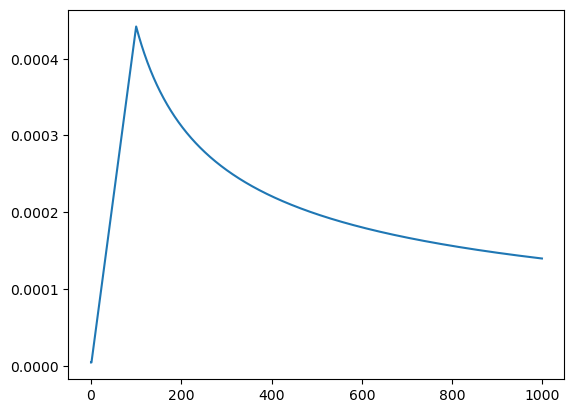

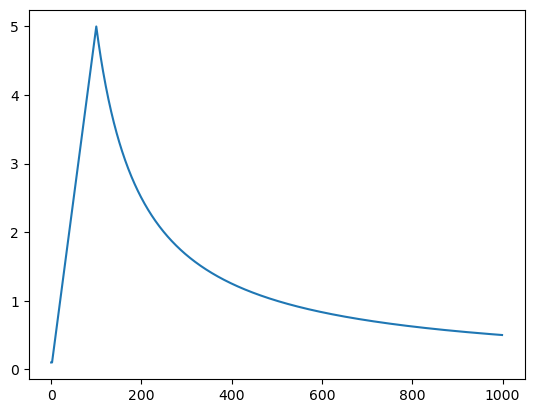

In [291]:
### 学习率调整策略
from matplotlib import pyplot as plt

def lr_lambda_fn(step, model_size, factor, warmup):
    if step == 0:
        step = 1

    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )



d_model = 512
factor = 0.1
warmup = 100

rates = []
steps = range(0, 1000)
for step in steps:
    r = lr_lambda_fn(step, d_model, factor, warmup)
    rates.append(r)

plt.plot(steps, rates)
plt.show()


### 自定义策略
def lr_lambda_fn(step, wramup):
    lr = 0
    if step <= wramup:
        lr = step / wramup * 5
    else:
        lr = wramup / step * 5
    return max(lr, 0.1)

rates = []
total_epoch = 1000
steps = range(total_epoch)
for step in steps:
    r = lr_lambda_fn(step, total_epoch/10)
    rates.append(r)

plt.plot(steps, rates)
plt.show()

In [211]:
# data_parallel.py    GPU负载均衡
import torch
from torch.nn.parallel.data_parallel import DataParallel
from torch.nn.parallel.parallel_apply import parallel_apply
from torch.nn.parallel._functions import Scatter

def scatter(inputs, target_gpus, chunk_sizes, dim=0):
    def scatter_map(obj):
        if isinstance(obj, torch.Tensor):
            try:
                return Scatter.apply(target_gpus, chunk_sizes, dim, obj)
            except Exception:
                print('obj', obj.size())
                print('dim', dim)
                print('chunk_sizes', chunk_sizes)
                quit()
        if isinstance(obj, tuple) and len(obj) > 0:
            return list(zip(*map(scatter_map, obj)))
        if isinstance(obj, list) and len(obj) > 0:
            return list(map(list, zip(*map(scatter_map, obj))))
        if isinstance(obj, dict) and len(obj) > 0:
            return list(map(type(obj), zip(*map(scatter_map, obj.items()))))
        return [obj for targets in target_gpus]
    try:
        return scatter_map(inputs)
    finally:
        scatter_map = None

def scatter_kwargs(inputs, kwargs, target_gpus, chunk_sizes, dim=0):
    """Scatter with support for kwargs dictionary"""
    inputs = scatter(inputs, target_gpus, chunk_sizes, dim) if inputs else []
    kwargs = scatter(kwargs, target_gpus, chunk_sizes, dim) if kwargs else []
    if len(inputs) < len(kwargs):
        inputs.extend([() for _ in range(len(kwargs) - len(inputs))])
    elif len(kwargs) < len(inputs):
        kwargs.extend([{} for _ in range(len(inputs) - len(kwargs))])
    inputs = tuple(inputs)
    kwargs = tuple(kwargs)
    return inputs, kwargs

class BalancedDataParallel(DataParallel):
    def __init__(self, gpu0_bsz, *args, **kwargs):
        self.gpu0_bsz = gpu0_bsz
        super().__init__(*args, **kwargs)

    def forward(self, *inputs, **kwargs):
        if not self.device_ids:
            return self.module(*inputs, **kwargs)
        if self.gpu0_bsz == 0:
            device_ids = self.device_ids[1:]
        else:
            device_ids = self.device_ids
        inputs, kwargs = self.scatter(inputs, kwargs, device_ids)
        if len(self.device_ids) == 1:
            return self.module(*inputs[0], **kwargs[0])
        replicas = self.replicate(self.module, self.device_ids)
        if self.gpu0_bsz == 0:
            replicas = replicas[1:]
        outputs = self.parallel_apply(replicas, device_ids, inputs, kwargs)
        return self.gather(outputs, self.output_device)

    def parallel_apply(self, replicas, device_ids, inputs, kwargs):
        return parallel_apply(replicas, inputs, kwargs, device_ids)

    def scatter(self, inputs, kwargs, device_ids):
        bsz = inputs[0].size(self.dim)
        num_dev = len(self.device_ids)
        gpu0_bsz = self.gpu0_bsz
        bsz_unit = (bsz - gpu0_bsz) // (num_dev - 1)
        if gpu0_bsz < bsz_unit:
            chunk_sizes = [gpu0_bsz] + [bsz_unit] * (num_dev - 1)
            delta = bsz - sum(chunk_sizes)
            for i in range(delta):
                chunk_sizes[i + 1] += 1
            if gpu0_bsz == 0:
                chunk_sizes = chunk_sizes[1:]
        else:
            return super().scatter(inputs, kwargs, device_ids)
        return scatter_kwargs(inputs, kwargs, device_ids, chunk_sizes, dim=self.dim)

# 四、==== data_processor.py ====== 构建词表, 数据预处理

In [212]:
####################### data_precessor.py ############################
######################################################################

import json
from collections import Counter

# 生成词表
def generate_vocab():
    # 中文特殊词  [屏蔽词，不知道的词，开头，结尾]
    en_vocab_set = ['<pad>','<unk>','<sos>','<eos>']
    # 英文特殊词  [屏蔽词，不知道的词，开头，结尾]
    zh_vocab_set = ['<pad>','<unk>','<sos>','<eos>']

    en_vocab_list = []
    zh_vocab_list = []

    # 解析训练数据
    with open(TRAIN_PATH, encoding='utf-8') as file:
        lines = json.loads(file.read())
        
        for en_sentence, zh_sentence in lines:
            # 收集英文分词后都数据
            en_vocab_list += divided_en(en_sentence)
            # 收集中文分词后都数据
            zh_vocab_list += divided_zh(zh_sentence)
    
    
    # 词表去重
    # zh_vocab_list中的词去重排序  [('词1',5),('词2',3)]
    zh_vocab_sort_kv = Counter(zh_vocab_list).most_common()
    # 去重后的词表  ['词1', '词2', '词3']
    zh_vocab_set += [k.lower() for k,v in zh_vocab_sort_kv]
    
    en_vocab_sort_kv = Counter(en_vocab_list).most_common()
    # 去重后的词表  ['词1', '词2', '词3']
    en_vocab_set += [k.lower() for k,v in en_vocab_sort_kv]
    
    print('en_vocab_set count:',len(en_vocab_set))
    print('zh_vocab_set count:',len(zh_vocab_set))

    
    # Python join() 方法用于将序列中的元素以指定的字符连接生成一个新的字符串。
    # 生成的词表写到文件中
    with open(EN_VOCAB_PATH, 'w', encoding='utf-8') as file:
        file.write('\n'.join(en_vocab_set))
        
    with open(ZH_VOCAB_PATH, 'w', encoding='utf-8') as file:
        file.write('\n'.join(zh_vocab_set))
    
    
# 生成词表    
if __name__ == '__main__':
    generate_vocab()
    
    


en_vocab_set count: 26
zh_vocab_set count: 20


# 5 ======== data_loader.py ======== 数据加载

In [223]:
################### data_loader.py ####################
#######################################################
import torch.utils.data as data
from torch.nn.utils.rnn import pad_sequence
import json
import torch


class Dataset(data.Dataset):
    def __init__(self, type='train'):
        super().__init__()
        if type == 'train':
            file_path = TRAIN_PATH
        elif type == 'val':
            file_path = VAL_PATH
            
        with open(file_path, encoding='utf-8') as file:
            self.lines = json.loads(file.read())
            
            # 词表
            _, self.en_vocab2id = get_vocab('en')
            _, self.zh_vocab2id = get_vocab('zh')

    
    def __len__(self):
        return len(self.lines)
            
    
    # 取第 index 单条样本
    def __getitem__(self, index):
        en_text, zh_text = self.lines[index]
            
        # 取出的句子进行分词，并转成索引表示
        source = [self.en_vocab2id.get(word.lower(), UNK_ID) for word in divided_en(en_text)]
        target = [self.zh_vocab2id.get(word.lower(), UNK_ID) for word in divided_zh(zh_text)]
        
        return source, target, zh_text

    
    # 数据对齐和整理
    # batch是 Dataset 中返回的样本数据，有三个 source, target, zh_text
    def collate_fn(self, batch):
        
        batch_source, batch_target, batch_tgt_text = zip(*batch)
    
        src_x = pad_sequence(sequences = [torch.LongTensor([SOS_ID]+src+[EOS_ID]) for src in batch_source],
                          batch_first = True,
                          padding_value = PAD_ID)
        
        # 批量句子掩码
        src_mask = get_padding_mask(src_x, padding_idx=PAD_ID)
    
       
        tgt_full = pad_sequence(sequences = [torch.LongTensor([SOS_ID]+src+[EOS_ID]) for src in batch_target],
                          batch_first = True,
                          padding_value = PAD_ID)
        # 目标输入值 不包括句子的最后一个字符
        tgt_x = tgt_full[:, :-1]
        # 目标预测值 不包括句子的第一个字符
        tgt_y = tgt_full[:, 1:]
        
        tgt_pad_mask = get_padding_mask(tgt_x, PAD_ID)
        tgt_subsqueent_mask = get_subsequent_mask(words_len=tgt_x.size(-1))
        tgt_mask = tgt_pad_mask | tgt_subsqueent_mask
        
        return src_x, src_mask, tgt_x, tgt_mask, tgt_y, batch_tgt_text 
    


# train_dataset = Dataset('train')
# train_loader = data.DataLoader(train_dataset, collate_fn=train_dataset.collate_fn, batch_size=BATCH_SIZE)

# val_dataset = Dataset('val')
# val_loader = data.DataLoader(val_dataset, collate_fn=val_dataset.collate_fn, batch_size=BATCH_SIZE)
     

# if __name__ == '__main__':
#     dataset = Dataset('val')    
    
#     # 加上collate_fn函数后，loader的返回值就是这个函数的返回值了
#     loader = data.DataLoader(dataset, collate_fn=dataset.collate_fn, batch_size=2)
#     print(next(iter(loader)))
    

#     exit()
#     # 解包操作
#     batch = [
#         [[1,2,3], ['a','b','c'], ['v','vb','vc']],
#         [[4,5,6], ['d','e','f'], ['v','vb','vc']],
#     ]
#     a,b,c = zip(*batch) # 解包操作
#     print(a)
#     print(b)
#     print(c)
    
#     print('*'*60)
    
#     # 等长填充
#     batch_src = [
#         [4,5,6],
#         [6,7]
#     ]

#     # 句子等长填充，比如批量获取两个句子，每个句子的长度不一样，这里可以把短的用0填充
#     src_pad = pad_sequence(sequences = [torch.LongTensor(src) for src in batch_src],
#                           batch_first = True,
#                           padding_value = 0)
#     print(src_pad)
    
#     # 句子前后加上开头和末尾标识
#     src_pad = pad_sequence(sequences = [torch.LongTensor([SOS_ID]+src+[EOS_ID]) for src in batch_src],
#                           batch_first = True,
#                           padding_value = 0)
    
#     print(src_pad)

# 6. ===== train.py ===== 训练文件

In [4]:
#####################  train.py  ##########################
###########################################################
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR


# 单轮训练
def run_epoch(loader, model, loss_fun, optimizer=None):
    # 本轮训练总损失
    total_loss = 0
    # 本轮 总批次
    total_batchs = 0
    
    # print(next(iter(loader)))

    # 加载数据并训练
    for src_x, src_mask, tgt_x, tgt_mask, tgt_y, batch_tgt_text in loader:
        src_x = src_x.to(DEVICE)
        src_mask = src_mask.to(DEVICE)
        tgt_x = tgt_x.to(DEVICE)
        tgt_mask = tgt_mask.to(DEVICE)
        tgt_y = tgt_y.to(DEVICE)
        
        # 模型输出 (batch, words_len, vocab_size) 
        # (批量个数(预测句子个数), 预测某个句子的单词个数, 预测的单词属于各个分类(vocab_size)的概率个数)
        predict = model(src_x, src_mask, tgt_x, tgt_mask)
        # print('predict.shape-> ', predict.shape)

        # 形状转变，把批量维度去掉 (batch, words_len, vocab_size)  -> (words_len, vocab_size)
        # 这样就变成了，预测的单词个数，以及单个单词属于各个分类的概率个数了
        predict = predict.reshape(-1, predict.shape[-1])
        
        # 形状转变，(batch, target_size) -> (target_size) 
        # batch: 批次
        # target_size:目标单词的个数, 里面放的是，目标单词的分类id
        # 比如 目标词表有vocab_size个单词, tgt_y放的就是这个单词在词表中所属的id(经过交叉熵函数后，这个位置对应的单词就变成了概率只为1的目标值了)
        tgt_y = tgt_y.reshape(-1)

        # 计算损失
        loss = loss_fun(predict, tgt_y)
        
        # 总损失
        total_loss += loss.item()
        total_batchs += 1
        
        # 反向传播
        if optimizer:
            # 梯度清零
            optimizer.zero_grad()
            # 计算梯度
            loss.backward()
            # 梯度更新
            optimizer.step()
        
        # 返回平均损失
        return total_loss / total_batchs
    

    
# 逐字生成预测值
def greedy_decode(model, src_x, src_mask, max_len):
    # 如果是多GPU,则原始模型存放在 model.module中
    model = model.module if MULTI_GPU else model
    
    # 录入的句子进行编码 
    memory = model.encode(src_x, src_mask)
    
    # 初始每个批次的目标值   src_x.size(0):是批次
    # 形状(batch, 单词个数)
    tgt_x = torch.tensor([[SOS_ID]] * src_x.size(0))
    
    tgt_x = tgt_x.to(DEVICE)
    
    # 开始生成目标值
    for _ in range(max_len):
        # 解码其中的批量掩码，这里不需要句子掩码
        tgt_mask = get_padding_mask(tgt_x,padding_idx=PAD_ID)
        
        # 解码 
        # 训练时output形状 (batch, 预测过程中句子长度, 词表长度)
        # 预测时output形状 (batch, 1, 词表长度)
        output = model.decode(tgt_x, tgt_mask, memory, src_mask, training=model.training) 
       
        # 用生成器取最后一个词  output最后形状 (batch, 1, 词表长度)
        #  output[:, -1, :].unsqueeze(1)
        output = model.generator(output)
        # [batch, 1, 20]

        # 获取生成词的词id   predict形状(批次, 1)  1表示生成一个词
        predict = torch.argmax(output, dim=-1)
        
        # 所有生成的词拼接上  形状(batch, 单词个数)  tgt_x就是预测的结果
        tgt_x = torch.concat([tgt_x, predict], dim=-1)
       
        # 碰到EOS_ID则结束预测, 如果有一个批次没结束则继续预测？
        if torch.all(predict == EOS_ID).item():
            break
            
    
    # 中文词表
    zh_id2vocab, _ = get_vocab('zh')
    # 生成的句子放到如下
    batch_tgt_text = []
    
    # 把预测的id，翻译成对应的词和句子，fangdao batch_tgt_text
    for tgt in tgt_x:
        # 单个句子
        text = []
        # tgt中放的是词id
        for word_id in tgt:
            if word_id == SOS_ID:
                continue
            elif word_id == EOS_ID:  # 碰到结束标识，改句子后面的解析就不要了
                break

            # 词id换成词，并放到text中
            text.append(zh_id2vocab[word_id])

        # 各个批次的句子放到 batch_tgt_text中
        batch_tgt_text.append(''.join(text))
        
    # 返回生成的句子
    return batch_tgt_text 


 
# 评估翻译效果    
def evaluate(loader, model, max_len):
    # 目标值，目标句子
    tgt_sentence = []
    # 翻译的句子
    prob_sentence = []

    for src_x, src_mask, tgt_x, tgt_mask, tgt_y, tgt_text in loader:
        src_x = src_x.to(DEVICE)
        src_mask = src_mask.to(DEVICE)
        
        # 翻译好的句子
        batch_prob_text = greedy_decode(model, src_x, src_mask, max_len)

        prob_sentence += batch_prob_text
        tgt_sentence += tgt_text
    
    # 返回评估分数
    return bleu_score(prob_sentence, [tgt_sentence]),prob_sentence,tgt_sentence

# 学习率
LR = 0.0001
# 训练次数
EPOCHS = 1000

    
if __name__ == '__main__':
    en_id2vocab,_ = get_vocab('en')
    zh_id2vocab,_ = get_vocab('zh')
    
    # 英文词表大小
    SRC_VOCAB_SIZE = len(en_id2vocab)
    # 中文词表大小
    TGT_VOCAB_SIZE = len(zh_id2vocab)

    # 实例化模型
    model = make_model(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, D_MODEL, N_HEAD, D_FF, N, DROPOUT)
    model = model.to(DEVICE)
     # 加载已经训练好的模型
    model.load_state_dict(torch.load('./model/best_model.pth', map_location=DEVICE))
    
    # 如果是多GPU
    if MULTI_GPU:
        # model = nn.DataParallel(model)
        model = BalancedDataParallel(BATCH_SIZE_GPU0, model, dim=0)

    
    
    ## 模型参数量
    total_params = sum(p.numel() for p in model.parameters())
    print('模型参数量: ',total_params)
    
    #损失函数和优化器
    loss_fun = CrossEntropyLoss(ignore_index=PAD_ID, label_smoothing=LABEL_SMOOTHING)
    optimizer = Adam(model.parameters(), lr=LR)
    # 动态调整学习率
    # lr_scheduler = LambdaLR(optimizer, lr_lambda=lambda step: lr_lambda_fn(step, 1))
    
    train_dataset = Dataset('train')
    train_loader = data.DataLoader(train_dataset, shuffle=True, collate_fn=train_dataset.collate_fn, batch_size=BATCH_SIZE)
    
    val_dataset = Dataset('val')
    val_loader = data.DataLoader(val_dataset, shuffle=True, collate_fn=val_dataset.collate_fn, batch_size=BATCH_SIZE)


    #### 训练  #########
    best_bleu_score = 74 # 最好的评估分数
    
    for i in range(EPOCHS):
        ########### 训练模式 ##############
        model.train()
        train_loss = run_epoch(train_loader, model, loss_fun,optimizer)

        # 动态调整学习率
        # lr_scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        print('当前学习率-> ',current_lr)
        
        ########### 验证流程 ##############
        model.eval()
        val_loss = run_epoch(val_loader, model, loss_fun,None)
        # 评估
        val_bleu_score,prob_sentence,tgt_sentence = evaluate(val_loader,model,MAX_LEN)
        
        # print('翻译: ',prob_sentence)
        # print('目标: ',tgt_sentence)
        print('>>eopch:',i, '; train_loss:',train_loss,'; val_loss:',val_loss, 'val_bleu_score:', val_bleu_score)
        
        # 如果当前评估分数好于 best_bleu_score，则保存模型
        if val_bleu_score > best_bleu_score:
            torch.save(model.state_dict(), './model/best_model.pth')
            best_bleu_score = val_bleu_score
            print('翻译: ',prob_sentence)
            print('目标: ',tgt_sentence)
            print('saveing-> ',train_loss, best_bleu_score)
            
            

NameError: name 'EN_VOCAB_PATH' is not defined

# 7.模型预测  predict.py

In [273]:
################################# config.py ################################
############################################################################

import torch
import os

BASE_PATH = '/Users/mashunfeng/My/AI/'

# 训练数据文件路径
TRAIN_PATH = os.path.join(BASE_PATH, 'news/train.json')
# 校验数据文件路径
VAL_PATH = os.path.join(BASE_PATH, 'news/dev.json')


# 存放中文词表的文件
ZH_VOCAB_PATH = os.path.join('/Users/mashunfeng/My/AI/', 'zh.txt')
# 存放英文词表的文件
EN_VOCAB_PATH = os.path.join('/Users/mashunfeng/My/AI/', 'en.txt')

# 特殊字符在词表中的id值
PAD_ID = 0  # 屏蔽词id
UNK_ID = 1  # 不知道的词id
SOS_ID = 2  # 开始标记id
EOS_ID = 3  # 结束标记id

# 子层编码和解码个数
N = 6
# 词向量维度
D_MODEL = 512
# 头数
N_HEAD = 8
# feedforward 维度
D_FF = 2048

DROPOUT = 0.1
# # 批次
BATCH_SIZE = 350
BATCH_SIZE_GPU0 = 50

# 学习率
LR = 1e-5
# 训练次数
EPOCHS = 10000

# 生成句子最大长度 
MAX_LEN = 50

# 标签平滑
LABEL_SMOOTHING = 0.1

# 运行设备
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 多GPU
MULTI_GPU = False
if torch.cuda.device_count() > 1:
    MULTI_GPU = True

if __name__ == '__main__':
    print(DEVICE)
    print('MULTI_GPU:', MULTI_GPU)

cpu
MULTI_GPU: False


In [2]:

if __name__ == '__main__':
    
    en_id2vocab, en_vocab2id  = get_vocab('en')
    zh_id2vocab, zh_vocab2id  = get_vocab('zh')
    
    # 英文词表大小
    SRC_VOCAB_SIZE = len(en_id2vocab)
    # 中文词表大小
    TGT_VOCAB_SIZE = len(zh_id2vocab)

    # 实例化模型
    model = make_model(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, D_MODEL, N_HEAD, D_FF, N, DROPOUT)
    model.to(DEVICE)
    
    model = BalancedDataParallel(BATCH_SIZE_GPU0, model, dim=0)

    # 加载模型参数
    model.load_state_dict(torch.load('/Users/mashunfeng/My/AI/best_model.pth', map_location=DEVICE))
    model = model.module
    model.eval()
    
    
    src_texts = [
        "Having gone through the long years, people have come to understand more than ever before how important this doctrine is and how precious peace can be.",
        "Everything is for the people, and everything relies on them.",
    ]

    # 获取句子在词表中的id表示
    src_tokens = [[en_vocab2id.get(word.lower(), UNK_ID) for word in divided_en(text)] 
                  for text in src_texts]
    # 句子收尾加上开始和结束标识
    src_tokens = [torch.LongTensor([SOS_ID]+src+[EOS_ID]) for src in src_tokens]
    
    # 长度不一致的用0填充
    src_x = pad_sequence(src_tokens, batch_first=True, padding_value=PAD_ID)
    print(src_x)
    # 掩码
    src_mask = get_padding_mask(src_x, PAD_ID)
    
    predict = greedy_decode(model, src_x, src_mask, max_len=10)
    print(predict)
    

NameError: name 'get_vocab' is not defined